## TODO:
- clean reviews
- doc2vec tutorial
- standardize anime data
- split into train and test (75,25 -- and do CV on train)
- consider using: svm, trees, logistic regression for anime quality classification

In [1]:
import os
import math
import itertools
import spacy

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import preprocess as prep
import utils_data as ud

from pprint import pprint

%matplotlib inline
%load_ext autoreload
%autoreload 2

pd.set_option('display.max_columns', 500)

In [2]:
animes_df = pd.read_hdf("data/mal_synopsis_vectors.hdf5", "table")

In [3]:
animes_df.head()

,mal_id,title,completed,dropped,favorites,members,on_hold,plan_to_watch,popularity,scored_by,total,watching,season_Fall,season_Spring,season_Summer,season_Winter,year_2005,year_2006,year_2007,year_2008,year_2009,year_2010,year_2011,year_2012,year_2013,year_2014,year_2015,year_2016,year_2017,year_2018,has_Prequel,has_Sequel,is_Light novel,is_Manga,is_Original,is_Visual novel,is_Action,is_Adventure,is_Comedy,is_Drama,is_Ecchi,is_Fantasy,is_Harem,is_Josei,is_Mystery,is_Romance,is_School,is_Sci-Fi,is_Seinen,is_Shoujo,is_Shounen,is_Slice of Life,is_Supernatural,synopsis_vector,is_Poor,is_Below_Average,is_Average,is_Above_Average,is_Excellent
0,10030,Bakuman.,173228,2949,1180,227168,5506,37421,399,136209,227184,8080,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,1,0,0,"[0.05492507, -0.0015817462, -0.023030212, 0.00...",0,0,0,0,1
1,10033,Toriko,27566,9598,739,79840,8156,22607,1224,25609,79849,11922,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,"[-0.06320087, -0.024732614, 0.04239033, -0.118...",0,0,1,0,0
2,10049,Nura: Rise of the Yokai Clan - Demon Capital,78096,1925,586,109049,2952,20868,946,56856,109074,5233,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,"[0.05399442, 0.02428066, -0.054012954, 0.01463...",0,0,1,0,0
3,10073,The Qwaser of Stigmata II,58933,4328,108,91658,2717,22014,1082,41283,91658,3666,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,"[-0.07319363, 0.033280805, 0.08378588, 0.10794...",1,0,0,0,0
4,10079,A Bridge to the Starry Skies,86865,3594,311,121486,2502,23732,837,64249,121486,4793,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,1,0,0,1,1,0,0,0,0,0,0,"[0.03607239, 0.10807864, -0.17572518, -0.01210...",1,0,0,0,0


## Some notes on preprocessing
The synopsis of each anime are lemmatized and converted into GloVe word embeddings using spaCy. Some keywords are kept after looking at the top 75 most common words, for example, words like "anime", "season", "plot", and "characters" might be important in this domain. Also words that capture sentiments such as "not", "but", "pretty", "love", are also kept. The word embeddings are than averaged to create document embeddings for each synopsis.

The studios of each animes were dropped due to there being a lot of studios to consider and there isn't enough data to justify incorporating studios as features. One mistake I may have made is excluding seasonal animes from 2005 to 2018, that do not have more than 70,000 members (i.e. people who have listed the anime in their profile) and only allowing TV animes (e.g. no OVAs, specials, movies).

From my experience, there are a few handful of staple studios in the anime industry such as KyoAnime, A-1 Pictures, ufotable, and Shaft. Even then, the quality of anime sometimes vary, for example A-1 Pictures have produced quality anime like AnoHana, but also animes like Eromanga (I liked it though). So it isn't as important as core features like genres.

There are a total of 39 genres, but the top 15 genres plus Shoujo and Jousei were kept. Though technically they aren't genres, they are targetted at certain demographs, just like Shounen and Seinen. It seems to be more useful than the other lower count features.

Most animes are adaptations of mangas or light novels. The source features are categorized as "manga", "light novel". "original", "visual novel", and "other".

After looking at the distribution of scores, I've decided to divide the scores into five categories with respect to their rating. The scores were binned based on quantiles of [0.2, 0.4, 0.8, 0.9]. They seem arbitrary, but the scores are right skewed. The average rating is about a 7.3, which should be then considered "average."

Rankings are dropped because it's based on score.

## Standardizing the data

In [4]:
animes_df.describe()

,mal_id,completed,dropped,favorites,members,on_hold,plan_to_watch,popularity,scored_by,total,watching,season_Fall,season_Spring,season_Summer,season_Winter,year_2005,year_2006,year_2007,year_2008,year_2009,year_2010,year_2011,year_2012,year_2013,year_2014,year_2015,year_2016,year_2017,year_2018,has_Prequel,has_Sequel,is_Light novel,is_Manga,is_Original,is_Visual novel,is_Action,is_Adventure,is_Comedy,is_Drama,is_Ecchi,is_Fantasy,is_Harem,is_Josei,is_Mystery,is_Romance,is_School,is_Sci-Fi,is_Seinen,is_Shoujo,is_Shounen,is_Slice of Life,is_Supernatural,is_Poor,is_Below_Average,is_Average,is_Above_Average,is_Excellent
count,915.000000,9.150000e+02,915.000000,915.000000,9.150000e+02,915.000000,915.000000,915.000000,9.150000e+02,9.150000e+02,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000
mean,18631.746448,1.602196e+05,9536.824044,4146.897268,2.468419e+05,8072.382514,52246.819672,618.477596,1.265625e+05,2.468562e+05,16780.510383,0.306011,0.274317,0.224044,0.195628,0.029508,0.039344,0.042623,0.059016,0.046995,0.055738,0.073224,0.080874,0.090710,0.116940,0.095082,0.100546,0.096175,0.073224,0.269945,0.449180,0.224044,0.440437,0.131148,0.069945,0.410929,0.142077,0.498361,0.246995,0.148634,0.262295,0.132240,0.021858,0.130055,0.350820,0.322404,0.159563,0.136612,0.059016,0.226230,0.184699,0.269945,0.201093,0.202186,0.397814,0.100546,0.098361
std,11982.255931,1.711732e+05,8415.332578,10162.148285,2.189061e+05,8210.564680,34312.296403,393.204373,1.361623e+05,2.189183e+05,21544.223562,0.461086,0.446413,0.417179,0.396901,0.169319,0.194519,0.202116,0.235784,0.211743,0.229540,0.260646,0.272791,0.287354,0.321524,0.293489,0.300892,0.294992,0.260646,0.444174,0.497683,0.417179,0.496711,0.337746,0.255194,0.492271,0.349320,0.500271,0.431499,0.355922,0.440123,0.338937,0.146300,0.336548,0.477488,0.467652,0.366400,0.343625,0.235784,0.418618,0.388266,0.444174,0.401037,0.401850,0.489714,0.300892,0.297965
min,15.000000,1.000000e+00,725.000000,77.000000,7.027000e+04,991.000000,5793.000000,1.000000,1.763500e+04,7.027000e+04,1630.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7746.500000,5.671000e+04,4529.500000,478.000000,1.072745e+05,3745.500000,28332.500000,277.500000,4.557700e+04,1.072720e+05,6472.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,18115.000000,1.004310e+05,7322.000000,1131.000000,1.693020e+05,5581.000000,41864.000000,577.000000,7.913200e+04,1.693020e+05,10244.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00

In [5]:
min_completed = animes_df["completed"].sort_values()[:5]
idx = min_completed.keys()
print(min_completed)

627        1
733        2
686        4
629        4
696    18968
Name: completed, dtype: int64


In [6]:
animes_df.iloc[idx]

,mal_id,title,completed,dropped,favorites,members,on_hold,plan_to_watch,popularity,scored_by,total,watching,season_Fall,season_Spring,season_Summer,season_Winter,year_2005,year_2006,year_2007,year_2008,year_2009,year_2010,year_2011,year_2012,year_2013,year_2014,year_2015,year_2016,year_2017,year_2018,has_Prequel,has_Sequel,is_Light novel,is_Manga,is_Original,is_Visual novel,is_Action,is_Adventure,is_Comedy,is_Drama,is_Ecchi,is_Fantasy,is_Harem,is_Josei,is_Mystery,is_Romance,is_School,is_Sci-Fi,is_Seinen,is_Shoujo,is_Shounen,is_Slice of Life,is_Supernatural,synopsis_vector,is_Poor,is_Below_Average,is_Average,is_Above_Average,is_Excellent
627,34566,Boruto: Naruto Next Generations,1,35716,2756,288816,30666,41164,301,111995,288873,181326,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,"[0.021947488, 0.04393465, -0.021062646, -0.032...",1,0,0,0,0
733,37991,JoJo`s Bizarre Adventure: Golden Wind,2,1641,3824,153112,3556,37754,647,45769,153138,110185,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,"[-0.028252449, 0.055085827, 0.012531352, 0.035...",0,0,0,0,1
686,35972,Fairy Tail Final Series,4,2946,2483,157341,4579,65199,625,30896,157405,84677,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,1,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,"[-0.007364329, 0.052913103, -0.051800165, 0.00...",0,0,0,1,0
629,34572,Black Clover,4,47270,4679,354945,22761,75446,213,125635,354962,209481,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,"[-0.028056385, 0.06826307, 0.007837369, -0.005...",1,0,0,0,0
696,36432,A Certain Magical Index III,18968,3667,493,102307,3644,49029,989,19736,102323,27015,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,"[-0.0108009195, -0.0032311669, 0.0087866625, 0...",1,0,0,0,0


There is a huge discrepancy between the number of people who have completed these animes. Upon closer inspection, these animes are currently still airing  as of May 2019.

In [7]:
min_popularity = animes_df["popularity"].sort_values()
idx = min_popularity.keys()[:5]
print(min_popularity[:5])

140    1
178    2
60     3
777    4
455    5
Name: popularity, dtype: int64


In [8]:
animes_df.iloc[idx]

,mal_id,title,completed,dropped,favorites,members,on_hold,plan_to_watch,popularity,scored_by,total,watching,season_Fall,season_Spring,season_Summer,season_Winter,year_2005,year_2006,year_2007,year_2008,year_2009,year_2010,year_2011,year_2012,year_2013,year_2014,year_2015,year_2016,year_2017,year_2018,has_Prequel,has_Sequel,is_Light novel,is_Manga,is_Original,is_Visual novel,is_Action,is_Adventure,is_Comedy,is_Drama,is_Ecchi,is_Fantasy,is_Harem,is_Josei,is_Mystery,is_Romance,is_School,is_Sci-Fi,is_Seinen,is_Shoujo,is_Shounen,is_Slice of Life,is_Supernatural,synopsis_vector,is_Poor,is_Below_Average,is_Average,is_Above_Average,is_Excellent
140,1535,Death Note,1401867,54998,99761,1684324,51374,104524,1,1152074,1684431,71668,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,"[-0.09916222, 0.1042756, -0.1009365, 0.0056355...",0,0,0,0,1
178,16498,Attack on Titan,1346675,34495,73150,1569373,26671,74785,2,1079911,1569557,86931,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,"[-0.066830486, -0.021153145, -0.05448076, 0.03...",0,0,0,0,1
60,11757,Sword Art Online,1299600,59618,54657,1504178,18589,70435,3,1045947,1504178,55936,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,"[-0.0417105, -0.019505387, -0.06542384, -0.074...",0,0,1,0,0
777,5114,Fullmetal Alchemist: Brotherhood,1048492,19302,125990,1427864,50714,201689,4,867978,1428204,108007,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,1,1,0,1,0,0,0,0,0,0,0,0,1,0,0,"[-0.042600017, 0.06929404, -0.0473744, 0.01969...",0,0,0,0,1
455,30276,One Punch Man,1091856,15980,38574,1275985,19069,82476,5,857945,1275955,66574,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,1,"[0.0015818091, 0.049827304, -0.06753425, 0.026...",0,0,0,0,1


Popularity is probably based on the number of members.

In [9]:
min_members = animes_df["members"].sort_values(ascending=False)
idx = min_members.keys()[:5]
print(min_members[:5])

140    1684324
178    1569373
60     1504178
777    1427864
455    1275985
Name: members, dtype: int64


In [10]:
animes_df.iloc[idx]

,mal_id,title,completed,dropped,favorites,members,on_hold,plan_to_watch,popularity,scored_by,total,watching,season_Fall,season_Spring,season_Summer,season_Winter,year_2005,year_2006,year_2007,year_2008,year_2009,year_2010,year_2011,year_2012,year_2013,year_2014,year_2015,year_2016,year_2017,year_2018,has_Prequel,has_Sequel,is_Light novel,is_Manga,is_Original,is_Visual novel,is_Action,is_Adventure,is_Comedy,is_Drama,is_Ecchi,is_Fantasy,is_Harem,is_Josei,is_Mystery,is_Romance,is_School,is_Sci-Fi,is_Seinen,is_Shoujo,is_Shounen,is_Slice of Life,is_Supernatural,synopsis_vector,is_Poor,is_Below_Average,is_Average,is_Above_Average,is_Excellent
140,1535,Death Note,1401867,54998,99761,1684324,51374,104524,1,1152074,1684431,71668,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,"[-0.09916222, 0.1042756, -0.1009365, 0.0056355...",0,0,0,0,1
178,16498,Attack on Titan,1346675,34495,73150,1569373,26671,74785,2,1079911,1569557,86931,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,"[-0.066830486, -0.021153145, -0.05448076, 0.03...",0,0,0,0,1
60,11757,Sword Art Online,1299600,59618,54657,1504178,18589,70435,3,1045947,1504178,55936,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,"[-0.0417105, -0.019505387, -0.06542384, -0.074...",0,0,1,0,0
777,5114,Fullmetal Alchemist: Brotherhood,1048492,19302,125990,1427864,50714,201689,4,867978,1428204,108007,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,1,1,0,1,0,0,0,0,0,0,0,0,1,0,0,"[-0.042600017, 0.06929404, -0.0473744, 0.01969...",0,0,0,0,1
455,30276,One Punch Man,1091856,15980,38574,1275985,19069,82476,5,857945,1275955,66574,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,1,"[0.0015818091, 0.049827304, -0.06753425, 0.026...",0,0,0,0,1


In [11]:
np.where(min_members.keys() != min_popularity.keys())

(array([ 23,  24,  85,  86, 105, 106, 123, 124, 165, 166, 167, 177, 178,
        194, 195, 196, 202, 203, 204, 205, 229, 230, 233, 234, 245, 246,
        250, 251, 258, 259, 268, 269, 270, 276, 277, 284, 285, 286, 305,
        306, 307, 310, 311, 325, 326, 334, 335, 349, 350, 351, 354, 355,
        370, 371, 386, 387, 417, 418, 423, 424, 428, 429, 430, 433, 434,
        445, 446, 463, 464, 466, 467, 499, 500, 501, 502, 514, 515, 517,
        518, 532, 533, 565, 566, 567, 568, 569, 570, 582, 583, 591, 592,
        595, 596, 599, 600, 604, 605, 615, 616, 624, 625, 638, 639, 641,
        642, 648, 649, 658, 659, 660, 661, 676, 677, 678, 679, 707, 708,
        714, 715, 716, 717, 723, 724, 732, 733, 734, 735, 746, 747, 749,
        754, 755, 757, 781, 782, 802, 803, 804, 805, 809, 810, 812, 814,
        816, 817, 843, 844, 845, 849, 850, 857, 858, 870, 871, 878, 879,
        890, 891, 892, 893, 894, 905, 906, 909, 910]),)

In [12]:
animes_df.iloc[[23,24, 893, 423]]

,mal_id,title,completed,dropped,favorites,members,on_hold,plan_to_watch,popularity,scored_by,total,watching,season_Fall,season_Spring,season_Summer,season_Winter,year_2005,year_2006,year_2007,year_2008,year_2009,year_2010,year_2011,year_2012,year_2013,year_2014,year_2015,year_2016,year_2017,year_2018,has_Prequel,has_Sequel,is_Light novel,is_Manga,is_Original,is_Visual novel,is_Action,is_Adventure,is_Comedy,is_Drama,is_Ecchi,is_Fantasy,is_Harem,is_Josei,is_Mystery,is_Romance,is_School,is_Sci-Fi,is_Seinen,is_Shoujo,is_Shounen,is_Slice of Life,is_Supernatural,synopsis_vector,is_Poor,is_Below_Average,is_Average,is_Above_Average,is_Excellent
23,10456,Horizon in the Middle of Nowhere,62630,8632,778,129352,5268,45010,786,47434,129352,7812,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,"[0.043428857, -0.015965685, -0.020185342, -0.0...",0,1,0,0,0
24,10460,You and Me.,54411,6040,1181,119471,4883,47869,854,42467,119482,6279,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,0,1,1,0,0,0,1,1,0,"[0.0012709072, 0.113316156, -0.10339561, 0.000...",0,0,1,0,0
893,9331,Dream Eater Merry,66033,6471,285,110547,4927,27471,931,50731,110542,5640,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,"[0.023885803, 0.07943787, -0.11332956, -0.0494...",1,0,0,0,0
423,28891,Haikyu!! 2nd Season,330219,2984,7828,416634,7230,47638,157,255554,416703,28632,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,1,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,1,0,0,"[-0.024489244, 0.061335627, -0.026409334, -0.0...",0,0,0,0,1


In [13]:
animes_df[["members", "popularity"]].corr()

,members,popularity
members,1.000000,-0.764449
popularity,-0.764449,1.000000


There seems to be quite a bit of correlation between the members and popularity. We could drop one of them to avoid the redundancy. The data will probably be easier to work with if popularity is dropped.

In [14]:
animes_df.drop(columns=["popularity"], axis=1, inplace=True)

In [15]:
animes_df.describe()

,mal_id,completed,dropped,favorites,members,on_hold,plan_to_watch,scored_by,total,watching,season_Fall,season_Spring,season_Summer,season_Winter,year_2005,year_2006,year_2007,year_2008,year_2009,year_2010,year_2011,year_2012,year_2013,year_2014,year_2015,year_2016,year_2017,year_2018,has_Prequel,has_Sequel,is_Light novel,is_Manga,is_Original,is_Visual novel,is_Action,is_Adventure,is_Comedy,is_Drama,is_Ecchi,is_Fantasy,is_Harem,is_Josei,is_Mystery,is_Romance,is_School,is_Sci-Fi,is_Seinen,is_Shoujo,is_Shounen,is_Slice of Life,is_Supernatural,is_Poor,is_Below_Average,is_Average,is_Above_Average,is_Excellent
count,915.000000,9.150000e+02,915.000000,915.000000,9.150000e+02,915.000000,915.000000,9.150000e+02,9.150000e+02,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000
mean,18631.746448,1.602196e+05,9536.824044,4146.897268,2.468419e+05,8072.382514,52246.819672,1.265625e+05,2.468562e+05,16780.510383,0.306011,0.274317,0.224044,0.195628,0.029508,0.039344,0.042623,0.059016,0.046995,0.055738,0.073224,0.080874,0.090710,0.116940,0.095082,0.100546,0.096175,0.073224,0.269945,0.449180,0.224044,0.440437,0.131148,0.069945,0.410929,0.142077,0.498361,0.246995,0.148634,0.262295,0.132240,0.021858,0.130055,0.350820,0.322404,0.159563,0.136612,0.059016,0.226230,0.184699,0.269945,0.201093,0.202186,0.397814,0.100546,0.098361
std,11982.255931,1.711732e+05,8415.332578,10162.148285,2.189061e+05,8210.564680,34312.296403,1.361623e+05,2.189183e+05,21544.223562,0.461086,0.446413,0.417179,0.396901,0.169319,0.194519,0.202116,0.235784,0.211743,0.229540,0.260646,0.272791,0.287354,0.321524,0.293489,0.300892,0.294992,0.260646,0.444174,0.497683,0.417179,0.496711,0.337746,0.255194,0.492271,0.349320,0.500271,0.431499,0.355922,0.440123,0.338937,0.146300,0.336548,0.477488,0.467652,0.366400,0.343625,0.235784,0.418618,0.388266,0.444174,0.401037,0.401850,0.489714,0.300892,0.297965
min,15.000000,1.000000e+00,725.000000,77.000000,7.027000e+04,991.000000,5793.000000,1.763500e+04,7.027000e+04,1630.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7746.500000,5.671000e+04,4529.500000,478.000000,1.072745e+05,3745.500000,28332.500000,4.557700e+04,1.072720e+05,6472.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,18115.000000,1.004310e+05,7322.000000,1131.000000,1.693020e+05,5581.000000,41864.000000,7.913200e+04,1.693020e+05,10244.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,31177.500000,1.950360e+05,12140.000000,

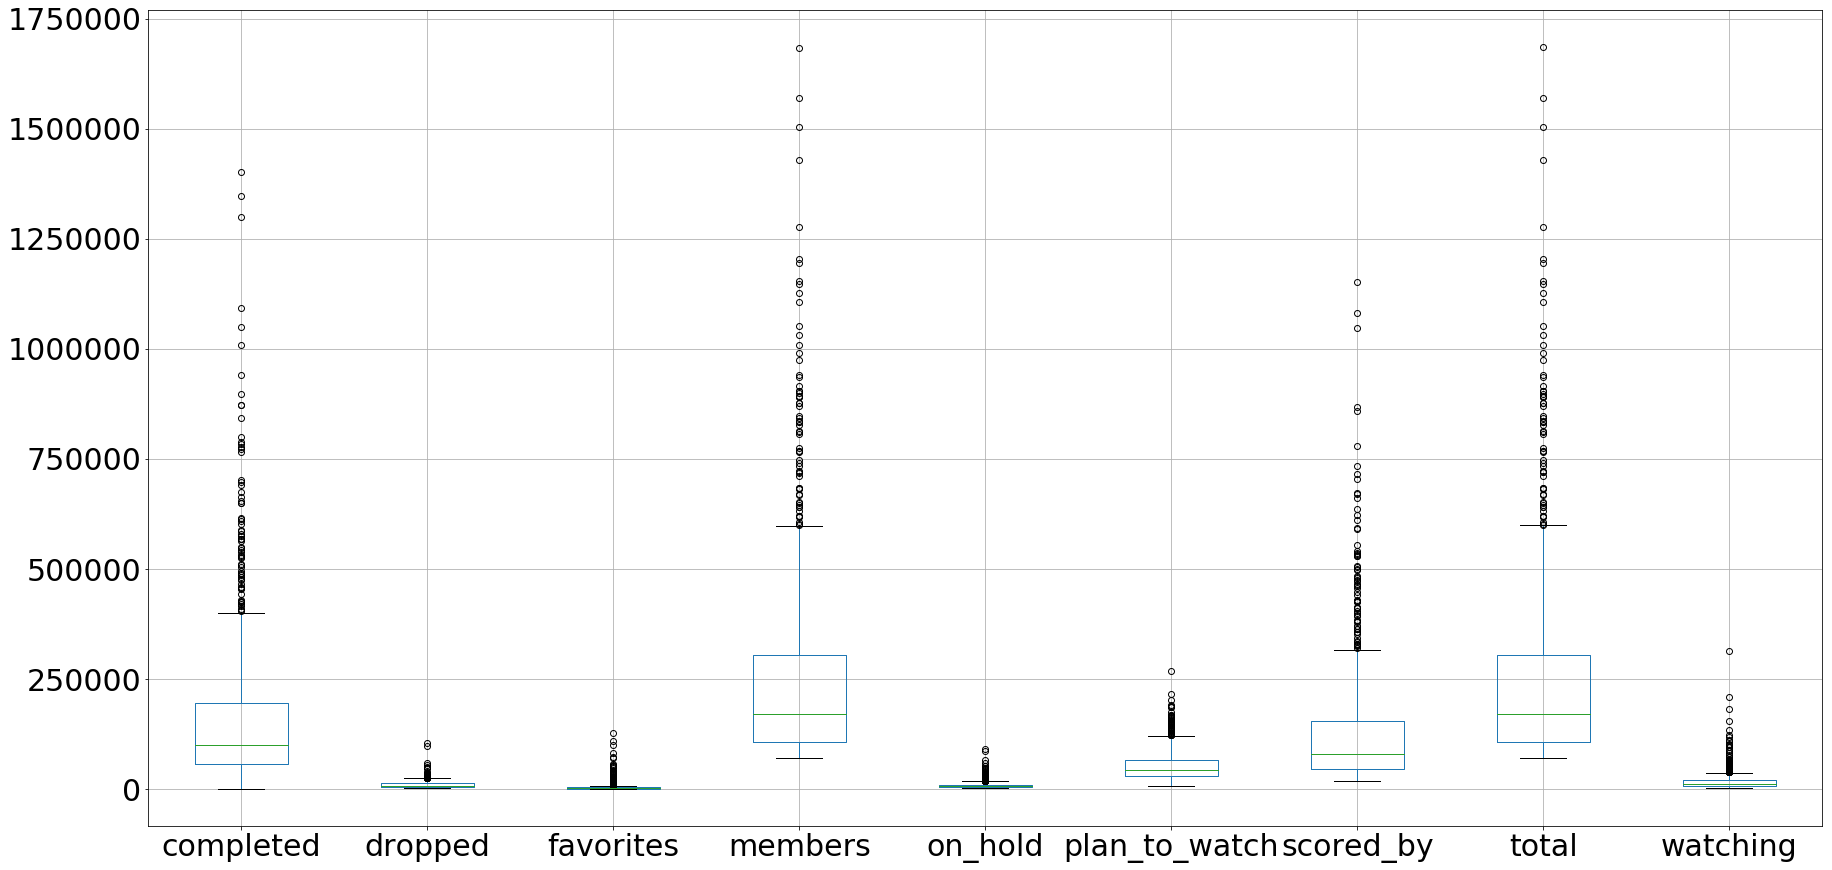

In [16]:
stats = ["completed", "dropped", "favorites", "members",
         "on_hold", "plan_to_watch", "scored_by", "total",
         "watching"]

animes_df.boxplot(column=stats, figsize=(30,15), fontsize=30)

In [17]:
animes_df[stats].corr()

,completed,dropped,favorites,members,on_hold,plan_to_watch,scored_by,total,watching
completed,1.000000,0.529646,0.770279,0.979257,0.604480,0.677715,0.996695,0.979258,0.488763
dropped,0.529646,1.000000,0.499590,0.624363,0.812035,0.476718,0.569417,0.624352,0.676802
favorites,0.770279,0.499590,1.000000,0.804548,0.704993,0.648630,0.797835,0.804536,0.558290
members,0.979257,0.624363,0.804548,1.000000,0.729091,0.782243,0.987736,1.000000,0.613375
on_hold,0.604480,0.812035,0.704993,0.729091,1.000000,0.735090,0.646012,0.729079,0.736685
plan_to_watch,0.677715,0.476718,0.648630,0.782243,0.735090,1.000000,0.692260,0.782242,0.505050
scored_by,0.996695,0.569417,0.797835,0.987736,0.646012,0.692260,1.000000,0.987735,0.546635
total,0.979258,0.624352,0.804536,1.000000,0.729079,0.782242,0.987735,1.000000,0.613383
watching,0.488763,0.676802,0.558290,0.613375,0.736685,0.505050,0.546635,0.613383,1.000000


Based on the boxplot, there is a lot of outliers, and from the correlation matrix, there is quite a bit of correlation. We'll use robust scaling and whitening.

I probably should have separated the data into training and testing at the very beginning, but I don't think I've done any major transformations on the data that is reliant on the training data.

In [18]:
from sklearn.model_selection import train_test_split

unrolled = animes_df.apply(prep.unroll_document_vector, 
                           args=("synopsis_vector",),
                           axis=1, result_type="expand")
unrolled.add_prefix("sv_")
animes_df = animes_df.join(unrolled, how="right")

rating_names = ["is_Poor", "is_Below_Average", "is_Average", "is_Above_Average", "is_Excellent"]
ratings = animes_df[rating_names]
animes_df.drop(columns=rating_names, axis=1, inplace=True)
animes_df = animes_df.join(ratings, how="right")

In [19]:
animes_df.head()

,mal_id,title,completed,dropped,favorites,members,on_hold,plan_to_watch,scored_by,total,watching,season_Fall,season_Spring,season_Summer,season_Winter,year_2005,year_2006,year_2007,year_2008,year_2009,year_2010,year_2011,year_2012,year_2013,year_2014,year_2015,year_2016,year_2017,year_2018,has_Prequel,has_Sequel,is_Light novel,is_Manga,is_Original,is_Visual novel,is_Action,is_Adventure,is_Comedy,is_Drama,is_Ecchi,is_Fantasy,is_Harem,is_Josei,is_Mystery,is_Romance,is_School,is_Sci-Fi,is_Seinen,is_Shoujo,is_Shounen,is_Slice of Life,is_Supernatural,synopsis_vector,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,is_Poor,is_Below_Average,is_Average,is_Above_Average,is_Excellent
0,10030,Bakuman.,173228,2949,1180,227168,5506,37421,136209,227184,8080,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,1,0,0,"[0.05492507, -0.0015817462, -0.023030212, 0.00...",0.054925,-0.001582,-0.023030,0.001837,-0.058916,0.020767,0.103268,-0.044993,-0.042293,1.363392,-0.005530,-0.061722,-0.103710,0.065830,0.038575,-0.049531,-0.023129,0.415847,0.019551,0.021869,0.065710,-0.138968,-0.040891,-0.143934,-0.006822,0.118222,0.006989,-0.123293,-0.001545,0.007006,0.005578,-0.040835,0.001453,-0.169356,0.074480,-0.088319,0.006837,-0.014429,0.022495,-0.100941,-0.029592,0.004229,0.015136,0.010769,-0.053390,-0.011896,0.052364,0.030738,-0.000194,-0.092781,0.010464,-0.053027,-0.077989,-0.054796,-0.035145,0.040334,0.060026,0.024201,-0.006362,-0.136720,-0.086299,-0.104930,-0.051046,-0.082023,0.063074,-0.019057,-0.034008,-0.032554,0.088011,-0.027442,0.029546,-0.044004,-0.119241,0.023618,-0.107424,0.006651,-0.089624,-0.058264,0.016375,0.154083,-0.005231,-0.014458,-0.075440,0.089041,-0.031919,-0.008177,-0.003568,-0.059995,-0.006662,-0.051673,-0.196045,-0.063909,-0.084527,0.066443,0.026021,-0.055525,0.059830,0.004648,-0.081881,0.065485,0.039643,-0.096733,-0.076950,-0.060712,0.038362,-0.810380,-0.024446,0.008528,0.055984,0.004946,0.024377,0.010949,0.020298,-0.081651,-0.052472,0.034252,-0.024716,0.074297,0.040505,0.012580,-0.032099,-0.040293,-0.001303,0.012879,0.199188,0.207073,-0.056438,0.029493,-0.027709,0.102555,-0.112325,-0.020857,0.087022,0.091445,0.030886,0.052612,-0.114230,-0.144826,0.084684,0.002910,-1.008510,-0.082579,-0.032851,-0.087111,-0.116704,-0.114477,0.062318,-0.064671,-0.025582,-0.079472,-0.001037,0.149659,0.030366,0.044257,0.040474,-0.037769,-0.131325,-0.140852,0.014106,-0.067238,-0.035240,-0.006736,-0.093754,-0.090203,0.083836,-0.051955,0.053140,-0.121756,0.056851,-0.068119,-0.059064,-0.017662,0.017881,-0.006630,0.005077,0.002732,-0.064522,0.036441,-0.147075,0.021764,0.045219,-0.031098,0.017603,-0.102408,0.018312,0.012652,-0.007010,0.042944,-0.045934,-0.058599,-0.028142,0.077364,-0.035431,0.037452,0.039553,-0.118018,0.000863,0.045151,0.133974,0.058165,0.053911,-0.057317,-0.034156,-0.107310,-0.058126,0.056278,-0.014121,0.028622,-0.013117,-0.000950,-0.129380,-0.039406,0.005323,-0.214727,-0.052356,0.124462,0.1160

In [20]:
len(animes_df.columns)

358

In [21]:
from sklearn.preprocessing import RobustScaler 
from sklearn.decomposition import PCA

robust_scaler = RobustScaler()
pca = PCA(whiten=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f210c319ac8>,
      dtype=object)

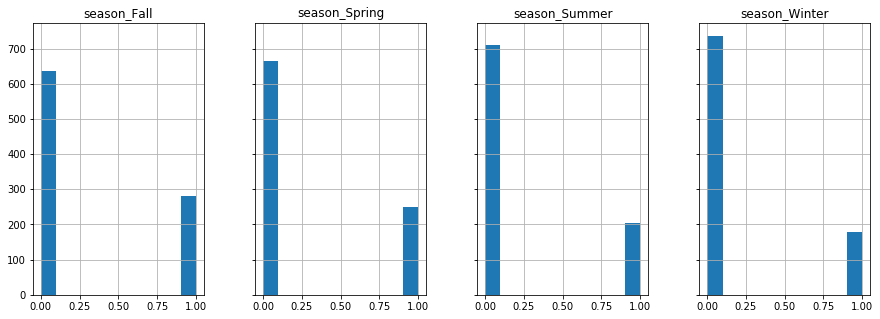

In [22]:
animes_df.hist(column=["season_Spring", "season_Summer", "season_Fall", "season_Winter"], 
               sharex=True, sharey=True, layout=(1,4), figsize=(15,5))

In [23]:
animes_df[stats].corr()

,completed,dropped,favorites,members,on_hold,plan_to_watch,scored_by,total,watching
completed,1.000000,0.529646,0.770279,0.979257,0.604480,0.677715,0.996695,0.979258,0.488763
dropped,0.529646,1.000000,0.499590,0.624363,0.812035,0.476718,0.569417,0.624352,0.676802
favorites,0.770279,0.499590,1.000000,0.804548,0.704993,0.648630,0.797835,0.804536,0.558290
members,0.979257,0.624363,0.804548,1.000000,0.729091,0.782243,0.987736,1.000000,0.613375
on_hold,0.604480,0.812035,0.704993,0.729091,1.000000,0.735090,0.646012,0.729079,0.736685
plan_to_watch,0.677715,0.476718,0.648630,0.782243,0.735090,1.000000,0.692260,0.782242,0.505050
scored_by,0.996695,0.569417,0.797835,0.987736,0.646012,0.692260,1.000000,0.987735,0.546635
total,0.979258,0.624352,0.804536,1.000000,0.729079,0.782242,0.987735,1.000000,0.613383
watching,0.488763,0.676802,0.558290,0.613375,0.736685,0.505050,0.546635,0.613383,1.000000
